# Modelagem Quântica da Molécula de H₂

Este notebook implementa a modelagem da molécula de H₂ utilizando **PennyLane** e **AWS Braket**. 
Ele realiza a simulação quântica da molécula de hidrogênio utilizando o **Variational Quantum Eigensolver (VQE)** para determinar a energia do estado fundamental. 

## Parâmetros do Modelo:

- **basis** (*str*): Base utilizada para representar a função de onda molecular. Exemplo: "sto-3g".
- **ansatz** (*str*): Tipo de circuito quântico usado para representar o estado quântico. Exemplo: "EfficientSU2".
- **backend** (*str*): Define onde a simulação será executada ("local" para simulador ou "aws" para rodar na AWS Braket).
- **shots** (*int*): Número de amostragens para a execução do circuito.
- **optimizer** (*str*): Algoritmo utilizado para otimizar os parâmetros do circuito ("GradientDescent", "COBYLA", "Adam", "Nelder-Mead").
- **fit** (*str*): Método de ajuste dos resultados (exemplo: "quadrático", "polinomial").
- **mapper** (*str*): Tipo de mapeamento de férmions para qubits (exemplo: "Jordan-Wigner", "Bravyi-Kitaev").

In [23]:
# Atualização de dependencias
!pip freeze > requirements.txt

# Importing modules

In [27]:
# Library imports
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

In [28]:
# AWS imports: Import Braket SDK modules
import math

from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

from braket.aws import AwsDevice, AwsQuantumTask
from braket.error_mitigation import Debias

In [5]:
#Specify the molecule we want to simulate
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [6]:
#Build the electronic Hamiltonian of the hydrogen molecule 
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", hamiltonian)

Number of qubits =  4
The Hamiltonian is  -0.04207255194743911 * I([0, 1, 2, 3]) + 0.17771358229091763 * Z(0) + 0.17771358229091766 * Z(1) + 0.17059759276836797 * (Z(0) @ Z(1)) + -0.24274501260941422 * Z(2) + 0.12293330449299356 * (Z(0) @ Z(2)) + 0.1676833885560135 * (Z(1) @ Z(2)) + 0.04475008406301993 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04475008406301993 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04475008406301993 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04475008406301993 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.24274501260941428 * Z(3) + 0.1676833885560135 * (Z(0) @ Z(3)) + 0.12293330449299356 * (Z(1) @ Z(3)) + 0.1762766139418181 * (Z(2) @ Z(3))


In [7]:
#Generate the vector representing the Hartree-Fock state
dev = qml.device("default.qubit", wires=qubits)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [8]:

#Initialize qubit registers
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

In [9]:

@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(hamiltonian)

In [10]:

#Use a basic gradient-descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [11]:

theta = np.array(0.0, requires_grad=True)

In [12]:


# Store values of the cost function
energy = [cost_fn(theta)]

# Store values of the circuit parameter
angle = [theta]

#Optimization over max of 30 steps
max_iterations = 30

#Aim to reach a convergence tolerance of 10^−6
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.8f}")

/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.20885146


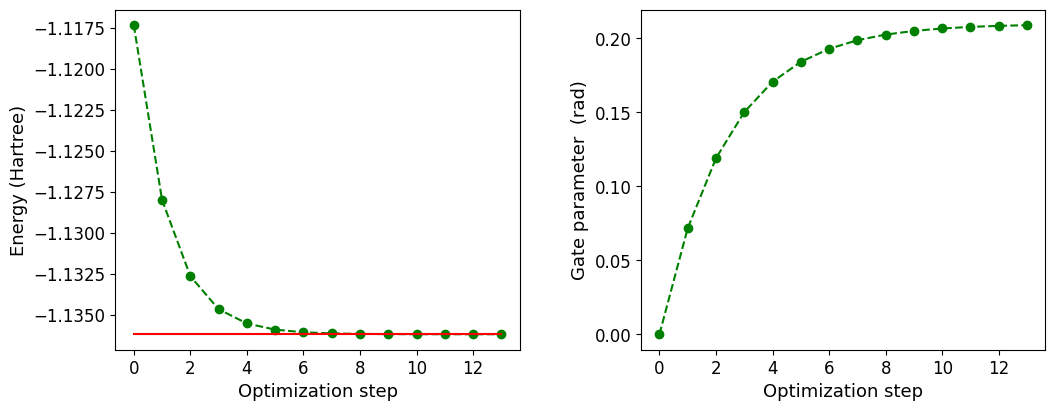

In [13]:

#Plotting the Values
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

#FCI energy classically computer
E_fci = -1.136189454088

#Add energy plot = Column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"", fontsize=15)
ax1.text(0, -1.1357, r"", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot = Column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter  (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In [22]:
import os
import numpy as np
import pennylane as qml
from braket.aws import AwsDevice
from braket.pennylane_plugin import BraketDevice

class H2Model:
    def __init__(self, basis="sto-3g", ansatz="EfficientSU2", backend="local", 
                 shots=1000, optimizer="COBYLA", fit="quadratic", mapper="Jordan-Wigner"):
        self.basis = basis
        self.ansatz = ansatz
        self.backend = backend
        self.shots = shots
        self.optimizer = optimizer
        self.fit = fit
        self.mapper = mapper
        self.device = self.setup_device()
        self.H = self.generate_hamiltonian()

    def setup_device(self):
        if self.backend == "aws":
            return BraketDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
        else:
            return qml.device("default.qubit", wires=4)

    def generate_hamiltonian(self):
        coeffs = [-0.242742, 0.177712, 0.177712, 0.122933, 0.122933, 0.167683, 0.167683]
        ops = [
            qml.Identity(wires=0),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=1),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=2),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=3),
            qml.PauliZ(wires=1) @ qml.PauliZ(wires=2),
            qml.PauliZ(wires=1) @ qml.PauliZ(wires=3),
            qml.PauliZ(wires=2) @ qml.PauliZ(wires=3)
        ]
        return qml.Hamiltonian(coeffs, ops)

    def run_vqe(self):
        @qml.qnode(self.device)
        def circuit(params):
            qml.BasisState(np.array([1, 1, 0, 0]), wires=[0, 1, 2, 3])
            qml.RY(params[0], wires=0)
            qml.RY(params[1], wires=1)
            qml.RY(params[2], wires=2)
            qml.RY(params[3], wires=3)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            return qml.expval(self.H)
        
        opt = qml.GradientDescentOptimizer(stepsize=0.4)
        params = np.random.randn(4, requires_grad=True)
        for i in range(100):
            params = opt.step(lambda p: circuit(p), params)
            energy = circuit(params)
            if i % 10 == 0:
                print(f"Step {i}: Energy = {energy}")
        return energy

ImportError: cannot import name 'BraketDevice' from 'braket.pennylane_plugin' (/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/braket/pennylane_plugin/__init__.py)

In [21]:
import os
import numpy as np
import pennylane as qml
from braket.aws import AwsDevice
from braket.pennylane_plugin import BraketDevice

class H2Model:
    def __init__(self, basis="sto-3g", ansatz="EfficientSU2", backend="local", 
                 shots=1000, optimizer="COBYLA", fit="quadratic", mapper="Jordan-Wigner"):
        self.basis = basis
        self.ansatz = ansatz
        self.backend = backend
        self.shots = shots
        self.optimizer = optimizer
        self.fit = fit
        self.mapper = mapper
        self.device = self.setup_device()
        self.H = self.generate_hamiltonian()

    def setup_device(self):
        if self.backend == "aws":
            return BraketDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
        else:
            return qml.device("default.qubit", wires=4)

    def generate_hamiltonian(self):
        coeffs = [-0.242742, 0.177712, 0.177712, 0.122933, 0.122933, 0.167683, 0.167683]
        ops = [
            qml.Identity(wires=0),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=1),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=2),
            qml.PauliZ(wires=0) @ qml.PauliZ(wires=3),
            qml.PauliZ(wires=1) @ qml.PauliZ(wires=2),
            qml.PauliZ(wires=1) @ qml.PauliZ(wires=3),
            qml.PauliZ(wires=2) @ qml.PauliZ(wires=3)
        ]
        return qml.Hamiltonian(coeffs, ops)

    def get_optimizer(self):
        optimizers = {
            "GradientDescent": qml.GradientDescentOptimizer(stepsize=0.4),
            "COBYLA": qml.optimize.COBYLAOptimizer(),
            "Adam": qml.AdamOptimizer(stepsize=0.1),
            "Nelder-Mead": qml.optimize.NelderMeadOptimizer(),
        }
        return optimizers.get(self.optimizer, qml.GradientDescentOptimizer(stepsize=0.4))

    def run_vqe(self):
        @qml.qnode(self.device)
        def circuit(params):
            qml.BasisState(np.array([1, 1, 0, 0]), wires=[0, 1, 2, 3])
            qml.RY(params[0], wires=0)
            qml.RY(params[1], wires=1)
            qml.RY(params[2], wires=2)
            qml.RY(params[3], wires=3)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            return qml.expval(self.H)
        
        opt = self.get_optimizer()
        params = np.random.randn(4, requires_grad=True)
        for i in range(100):
            params = opt.step(lambda p: circuit(p), params)
            energy = circuit(params)
            if i % 10 == 0:
                print(f"Step {i}: Energy = {energy}")
        return energy

# Executar o modelo para H2
test_H2 = H2Model(optimizer="COBYLA")
energy_H2 = test_H2.run_vqe()
print(f"Energia do estado fundamental do H2: {energy_H2:.6f} Ha")

ImportError: cannot import name 'BraketDevice' from 'braket.pennylane_plugin' (/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/braket/pennylane_plugin/__init__.py)

In [15]:
import os
import numpy as np
import pennylane as qml
from pennylane import qchem
from braket.aws import AwsDevice
from braket.pennylane_plugin import BraketDevice

class H2Model:
    def __init__(self, basis="sto-3g", ansatz="EfficientSU2", backend="local", 
                 shots=1000, optimizer="COBYLA", fit="quadratic", mapper="Jordan-Wigner", distance=0.735):
        """
        Inicializa o modelo para a molécula de H₂.
        """
        self.basis = basis
        self.ansatz = ansatz
        self.backend = backend
        self.shots = shots
        self.optimizer = optimizer
        self.fit = fit
        self.mapper = mapper
        self.distance = distance
        self.device = self.setup_device()
        self.H, self.qubits = self.generate_hamiltonian()

    def setup_device(self):
        """Define o backend utilizado para a execução da simulação."""
        if self.backend == "aws":
            return BraketDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
        else:
            return qml.device("default.qubit", wires=4)

    def generate_hamiltonian(self):
        """Gera o Hamiltoniano da molécula de H₂ com base na distância parametrizada."""
        symbols = ["H", "H"]
        coordinates = [0.0, 0.0, 0.0, 0.0, 0.0, self.distance]
        H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, basis=self.basis)
        return H, qubits

    def get_optimizer(self):
        """Seleciona o algoritmo de otimização com base na escolha do usuário."""
        optimizers = {
            "GradientDescent": qml.GradientDescentOptimizer(stepsize=0.4),
            "COBYLA": qml.optimize.COBYLAOptimizer(),
            "Adam": qml.AdamOptimizer(stepsize=0.1),
            "Nelder-Mead": qml.optimize.NelderMeadOptimizer(),
        }
        return optimizers.get(self.optimizer, qml.GradientDescentOptimizer(stepsize=0.4))

    def run_vqe(self):
        """Executa o algoritmo VQE para encontrar a energia do estado fundamental."""
        @qml.qnode(self.device)
        def circuit(params):
            qml.BasisState(np.array([1, 1, 0, 0]), wires=range(self.qubits))
            qml.RY(params[0], wires=0)
            qml.RY(params[1], wires=1)
            qml.RY(params[2], wires=2)
            qml.RY(params[3], wires=3)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            return qml.expval(self.H)
        
        opt = self.get_optimizer()
        params = np.random.randn(self.qubits, requires_grad=True)
        for i in range(100):
            params = opt.step(lambda p: circuit(p), params)
            energy = circuit(params)
            if i % 10 == 0:
                print(f"Step {i}: Energy = {energy}")
        return energy

# Executar o modelo para H2 com distância parametrizada
test_H2 = H2Model(optimizer="COBYLA", distance=0.735)
energy_H2 = test_H2.run_vqe()
print(f"Energia do estado fundamental do H2 (d={test_H2.distance} Å): {energy_H2:.6f} Ha")

ModuleNotFoundError: No module named 'braket'

In [8]:
!pip install numpy==1.24.3


  Using cached numpy-1.24.3.tar.gz (10.9 MB)
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
           ~~~~~~~~^^^^^^^^^^^^^^^
  File "/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/Users/avilamrs/Repositories/Artigo/Clifford_ZNE_artigo/venv01/lib/python3.13/site-packages/pip/_internal/commands/install.py", line 386, in run
    requirement_set = resolver.resolve(
        reqs,

In [7]:
!pip uninstall numpy -y


Found existing installation: numpy 2.2.3
Uninstalling numpy-2.2.3:
  Successfully uninstalled numpy-2.2.3
